## 1. 라이브러리 불러오기

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import summary
import matplotlib.pyplot as plt

%matplotlib inline
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## 2. MNIST 데이터셋 불러오기

In [68]:
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [88]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

data, label = next(iter(train_loader))
data.shape, label.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [89]:
image_show = data[0, 0, :, :]
image_show.shape

torch.Size([28, 28])

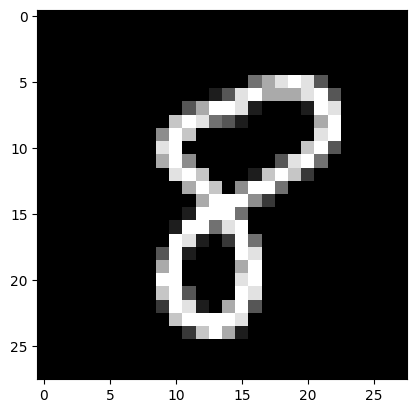

In [90]:
plt.imshow(image_show, "gray")
plt.show()

In [91]:
def conv2d_output_size(input_size, kernel_size, stride=1, padding=0):
    height, width = input_size

    # Convolution 공식 적용
    out_height = (height + 2 * padding - kernel_size) // stride + 1
    out_width = (width + 2 * padding - kernel_size) // stride + 1

    return out_height, out_width

In [92]:
output_size = conv2d_output_size((28, 28), 3, 1, 1)  # (height, width), kernel_size, stride, padding
print(f"Output feature map size: {output_size}")

Output feature map size: (28, 28)


## 3. CNN 모델 구성

In [93]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    

model = CNN().to(device)
summary(model, input_size=(64, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 10]                  --
├─Conv2d: 1-1                            [64, 32, 28, 28]          320
├─ReLU: 1-2                              [64, 32, 28, 28]          --
├─MaxPool2d: 1-3                         [64, 32, 14, 14]          --
├─Conv2d: 1-4                            [64, 64, 14, 14]          18,496
├─ReLU: 1-5                              [64, 64, 14, 14]          --
├─MaxPool2d: 1-6                         [64, 64, 7, 7]            --
├─Flatten: 1-7                           [64, 3136]                --
├─Linear: 1-8                            [64, 128]                 401,536
├─ReLU: 1-9                              [64, 128]                 --
├─Linear: 1-10                           [64, 32]                  4,128
├─ReLU: 1-11                             [64, 32]                  --
├─Linear: 1-12                           [64, 10]                  330
T

## 4. 학습 & 평가 함수 정의

In [94]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()  # 모델을 학습 모드로 설정

    running_loss = 0.0 # 미니 배치별 loss값을 누적할 변수

    for data, labels in train_loader: # 미니 배치 별 파라미터 업데이트 수행
        data, labels = data.to(device), labels.to(device) # 미니 배치별 데이터와 레이블 장치 할당

        # 순전파
        outputs = model(data)

        # 손실 계산
        loss = criterion(outputs, labels)

        # 기울기 초기화
        optimizer.zero_grad()

        # 역전파
        loss.backward()

        # 파라미터 업데이트
        optimizer.step()

        # 손실 누적
        running_loss += loss.item()

    # 현재 Epoch의 평균 손실 값 계산 및 반환
    return running_loss / len(train_loader)

In [95]:
# 평가 함수 정의
def evaluate(model, test_loader, criterion, device):
    model.eval()  # 모델을 평가 모드로 설정

    running_loss = 0.0 # 미니 배치별 loss값을 누적할 변수

    with torch.no_grad():  # 평가 중에는 기울기 계산을 하지 않음
        for data, labels in test_loader: # 미니 배치 별 손실 계산
            data, labels = data.to(device), labels.to(device) # 미니 배치별 데이터와 레이블 장치 할당

            # 순전파
            outputs = model(data)

            # 손실 계산
            loss = criterion(outputs, labels)

            # 손실 누적
            running_loss += loss.item()


    # 현재 Epoch의 평균 손실 값 계산 및 반환
    return running_loss / len(test_loader)

In [96]:
criterion = nn.CrossEntropyLoss()  # 다중 클래스 분류를 위한 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam 옵티마이저

train_losses = []
test_losses = []

# 학습 횟수 만큼 반복
for epoch in range(10):

    # 모델 학습(학습데이터)
    train_loss = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    # 모델 평가 (평가데이터)
    test_loss = evaluate(model, test_loader, criterion, device)
    test_losses.append(test_loss)

    print(f'Epoch {epoch+1} Train Loss : {train_loss} Test Loss : {test_loss}')

Epoch 1 Train Loss : 0.2323125587018735 Test Loss : 0.06468156258950816
Epoch 2 Train Loss : 0.0599875486441461 Test Loss : 0.046212096553619145
Epoch 3 Train Loss : 0.04218191747478684 Test Loss : 0.05434799528325564
Epoch 4 Train Loss : 0.03329442063876952 Test Loss : 0.0385051008796471
Epoch 5 Train Loss : 0.025021358685412092 Test Loss : 0.03336949569950248
Epoch 6 Train Loss : 0.02135163888754472 Test Loss : 0.03429550523906305
Epoch 7 Train Loss : 0.018002128127488498 Test Loss : 0.03387588619059631
Epoch 8 Train Loss : 0.013262335202806596 Test Loss : 0.03028979408308532
Epoch 9 Train Loss : 0.011989280454096566 Test Loss : 0.0272184218629133
Epoch 10 Train Loss : 0.009923777937965613 Test Loss : 0.030470613437464808
